In [20]:
import msgpack as mp
import msgpack_numpy as mpn
import numpy as np
import cv2
import matplotlib.pyplot as plt
import sys
import os

sys.path.append(os.path.join(os.getcwd(), ".."))
from support.generate_ar_data import *
from support.pd_support import *
from support.calculations_support import *
from support.mecanum_calculations import *
from support.ar_calculations import *
from scipy.signal import savgol_filter

In [21]:
_parent_folder = "multi_cam_nov_14"
_base_pth = os.path.dirname(os.getcwd())
_base_pth = os.path.join(_base_pth, "recording_programs", "test_data", _parent_folder)
_base_pth

'c:\\Users\\CMC\\Documents\\openposelibs\\pose\\armbo\\recording_programs\\test_data\\multi_cam_nov_14'

In [22]:
""" read excel sheet"""
folder_df = pd.read_excel(os.path.join(_base_pth, "00_analysis", "calibration_files_corrected.xlsx"))
folder_df

,folder_name,calibration_folder,flip
0,sk16_15_forward_fast,calibration_15fps_sk,False
1,sk16_15_forward_fast_2,calibration_15fps_sk,False
2,sk16_15_forward_medium,calibration_15fps_sk,False
3,sk16_15_forward_medium_2,calibration_15fps_sk,False
4,sk16_15_forward_slow,calibration_15fps_sk,False
...,...,...,...
84,sk16_60_sideways_fast_2,calibration_60fps_quad_sk_3,False
85,sk16_60_sideways_medium,calibration_60fps_quad_sk_3,False
86,sk16_60_sideways_medium_2,calibration_60fps_quad_sk_3,False
87,sk16_60_sideways_slow,calibration_60fps_quad_sk_3,False


In [23]:
folder_no = 26

#calibration path
_calib_pth = os.path.join(_base_pth, folder_df["calibration_folder"][folder_no])
_webcam_calib_pth = os.path.join(_calib_pth, "webcam_calibration.msgpack")

#rotation matrix path
_rotmat_pth = _calib_pth
_webcam_pth = os.path.join(_base_pth, folder_df["folder_name"][folder_no])
_webcam_rotmat_pth = os.path.join(_rotmat_pth, "webcam_rotmat.msgpack")
_webcam_video_pth = os.path.join(_webcam_pth, "webcam_color.msgpack")

#timestamp path
_webcam_timestamp_pth = os.path.join(_webcam_pth, "webcam_timestamp.msgpack")
_webcam_calib_pth

'c:\\Users\\CMC\\Documents\\openposelibs\\pose\\armbo\\recording_programs\\test_data\\multi_cam_nov_14\\calibration_15fps_sk\\webcam_calibration.msgpack'

In [24]:
#open the calibration files
with open(_webcam_calib_pth, "rb") as f:
    webcam_calib = mp.Unpacker(f, object_hook=mpn.decode)
    _temp = next(webcam_calib)
    _webcam_cam_mat = _temp[0]
    _webcam_dist = _temp[1]

# open rotation matrix and org
with open(_webcam_rotmat_pth, "rb") as f:
    webcam_rotmat = mp.Unpacker(f, object_hook=mpn.decode)
    _webcam_rot = next(webcam_rotmat)
    _webcam_org = next(webcam_rotmat)
print("camera matrix", _webcam_cam_mat)
print("distortion", _webcam_dist)

camera matrix [[874.59046783   0.         366.44018221]
 [  0.         881.45673935 268.42500753]
 [  0.           0.           1.        ]]
distortion [[ 1.29040791e-01 -1.00989575e-01  8.05214561e-03  2.63742822e-03
  -5.99529755e+00]]


In [25]:
_w_df = get_ar_pose_data(_webcam_video_pth, _webcam_cam_mat, _webcam_dist, is_color=False, single_file=True, flip_frame=False)

_w_df = add_time_from_file(_w_df, _webcam_timestamp_pth)

In [26]:
#reading mocap df
_mocap_pth = os.path.join(_base_pth, "sk16", folder_df.folder_name[folder_no] + ".csv")
_m_df, st_time = read_df_csv(_mocap_pth)
#getting center

_m_df["x"] = _m_df["lb_x"] + _m_df["rb_x"] + _m_df["lt_x"] + _m_df["rt_x"]
_m_df["y"] = _m_df["lb_y"] + _m_df["rb_y"] + _m_df["lt_y"] + _m_df["rt_y"]
_m_df["z"] = _m_df["lb_z"] + _m_df["rb_z"] + _m_df["lt_z"] + _m_df["rt_z"]

_m_df["x"] = _m_df["x"] / 4
_m_df["y"] = _m_df["y"] / 4
_m_df["z"] = _m_df["z"] / 4

_m_df = add_datetime_col(_m_df, st_time,_name="seconds")

In [27]:
"""
axis definition

_xvec = bottom right
org = bottom left
_yvec = top left
"""

_rotmat_i = []
for i in range(len(_m_df)):
    
    _x_vec = _m_df[["rb_x", "rb_y", "rb_z"]].loc[i].values
    _x_vec = np.reshape(_x_vec, (3,1))
    _org = _m_df[["lb_x", "lb_y", "lb_z"]].loc[i].values
    _org = np.reshape(_org, (3,1))
    _y_vec = _m_df[["lt_x", "lt_y", "lt_z"]].loc[i].values
    _y_vec = np.reshape(_y_vec, (3,1))
    
    _rotmat_i.append(calculate_rotmat_from_xyo(_x_vec, _y_vec, _org))
    

In [28]:
# calculating del rotmat
_del_r = []
for i in range(len(_rotmat_i)):
    _del_r.append(_rotmat_i[i].T@_rotmat_i[0])

_del_r[0]

array([[ 1.00000000e+00, -5.19326426e-19,  1.56896738e-18],
       [-5.19326426e-19,  1.00000000e+00, -7.25411708e-19],
       [ 1.56896738e-18, -7.25411708e-19,  1.00000000e+00]])

In [29]:
_theta_x = []
_theta_y = []
_theta_z = []

for i in _del_r:
    _theta_x.append(np.arctan2(i[2,1], i[2,2]))
    _theta_y.append(np.arctan2(-i[2,0], np.sqrt(i[2,1]**2 + i[2,2]**2)))
    _theta_z.append(np.arctan2(i[1,0], i[0,0]))
    
_theta_x = np.array(_theta_x)
_theta_y = np.array(_theta_y)
_theta_z = np.array(_theta_z)

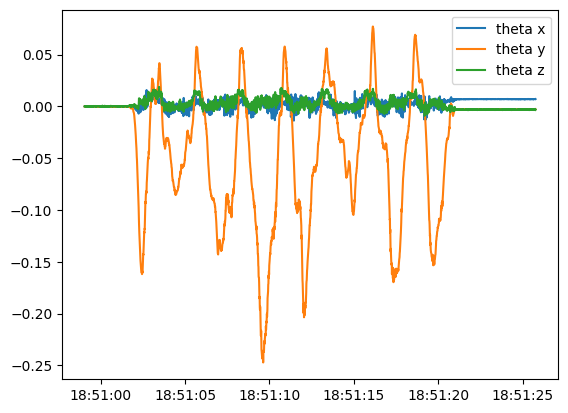

In [30]:
plt.plot(_m_df["time"], _theta_x, label="theta x")
plt.plot(_m_df["time"], _theta_y, label="theta y")
plt.plot(_m_df["time"], _theta_z, label="theta z")
plt.legend()

In [31]:
_w_df["yaw"] = _w_df["yaw"].interpolate(method='polynomial', order=2, limit_direction="backward")
_w_df["pitch"] = _w_df["pitch"].interpolate(method='polynomial', order=2, limit_direction="backward")
_w_df["roll"] = _w_df["roll"].interpolate(method='polynomial', order=2, limit_direction="backward")

In [32]:
""" angle from aruco marker"""

_ar_rotmat_i = []
for i in range(len(_w_df)):
    
    _val = _w_df[["yaw", "pitch", "roll"]].loc[i].values
    _val = np.reshape(_val, (3,1))
    _ar_rotmat_i.append(cv2.Rodrigues(_val))



In [33]:
_del_ar_r = []

# _rotmat_la_0 = _webcam_rot.T @ _ar_rotmat_i[0][0]
for i in range(len(_ar_rotmat_i)):
    # _rotmat_la = _webcam_rot.T @ _ar_rotmat_i[i][0]
    _del_ar_r.append(_ar_rotmat_i[0][0].T@_ar_rotmat_i[i][0])

In [34]:
#getting angle from rotmat

_ar_theta_x = []
_ar_theta_y = []
_ar_theta_z = []

for i in _del_ar_r:
    _ar_theta_x.append(np.arctan2(i[2,1], i[2,2]))
    _ar_theta_y.append(np.arctan2(-i[2,0], np.sqrt(i[2,1]**2 + i[2,2]**2)))
    _ar_theta_z.append(np.arctan2(i[1,0], i[0,0]))
    
_ar_theta_x = np.array(_ar_theta_x)
_ar_theta_y = np.array(_ar_theta_y)
_ar_theta_z = np.array(_ar_theta_z)

In [35]:
_ar_ang_df = pd.DataFrame({"time": _w_df["time"], "theta_x": _ar_theta_x, "theta_y": _ar_theta_y, "theta_z": _ar_theta_z})

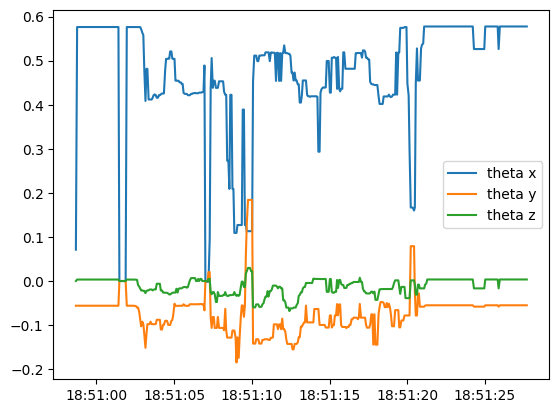

In [36]:
plt.plot(_w_df["time"], _ar_ang_df["theta_x"].rolling(13).median(), label="theta x")
plt.plot(_w_df["time"], _ar_ang_df["theta_y"].rolling(13).median(), label="theta y")
plt.plot(_w_df["time"], _ar_ang_df["theta_z"].rolling(13).median(), label="theta z")
plt.legend()

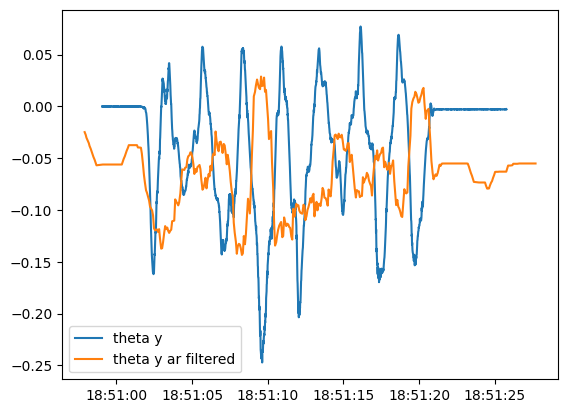

In [39]:
plt.plot(_m_df["time"], _theta_y, label="theta y")
# plt.plot(_w_df["time"], _ar_ang_df["theta_y"].rolling(7).median(), label="theta y ar")
plt.plot(_w_df["time"], savgol_filter(_ar_ang_df["theta_y"].values, 21, 1, mode='nearest'), label="theta y ar filtered")
plt.legend()